# Configs

In [1]:
%load_ext autoreload
%autoreload 3
## other standard packages
import os
import sys
## Env variables and preparation stuffs
sys.path.insert(0, "../")
sys.path.insert(0, "./")
from src_code.task_utils.config_parser import ConfigParser
configs_dict = {
    "data_configs": {
        "train_path": "datasets/utn_dataset_curated/part2/train",
        "val_path": "datasets/utn_dataset_curated/part2/val",
        "test_path": "datasets/utn_dataset_curated/part2/test",
        "preprocessing_related": {
            "mean": 0.5,  # for raw_image normalisation
            "std": 0.5,  # for raw_image normalisation
            "downscale_factor": 4,
        },
        "dataset_related": {
            "train_preprocessed_dir": "../datasets/utn_dataset/part2/train/images/",
            "val_preprocessed_dir": "../datasets/utn_dataset/part2/val/images/",
            "test_preprocessed_dir": "../datasets/utn_dataset/part2/test/images/",
            "train_labels_dir": "../datasets/utn_dataset/part2/train/labels/",
            "val_labels_dir": "../datasets/utn_dataset/part2/val/labels/",
            "augment": True,
            "shuffle": False,
        },
        "augmentation_related": {
            "flip_prob": 0.5,
            "scale_range": (0.8, 1.2),
            "zoom_prob": 0,
            "saturation_prob": 0
        },
    },
    "model_configs": {
        "epochs": 1,
        "batch_size": 32,
        "device": "cuda",  # either "cpu" or "cuda"
        "checkpoint": None,
        "backbone": {
            "name": "VGG16",
            "num_stages": 6,
        },
        "loss": {
            "alpha": 1,  # loss = alpha*loc_loss + cls_loss
            "pos_box_threshold": 0.5,  # a default box is marked positive if it has (> pos_box_threshold) IoU score with any of the groundtruth boxes
            "hard_neg_pos": 3,  # num of negative boxes = hard_neg_pos * num_positive_boxes
        },
        "optim": {
            "name": "SGD",
            "lr": 0.001,
            "momentum": 0.9,
            "weight_decay": 0.0005,
        },
        "scheduler": {
            "name": "MultiStepLR",
            "milestones": [155, 195],
            "gamma": 0.1,
        },
    },
    "task_configs": {
        "img_height": 160,  # original image height
        "img_width": 640,  # original image width
        "debug": True,  # if True will display a lot of intermediate information for debugging purposes
        "log_expt": False,  # whether to log the experiment online or not
        "num_classes": 37,  # A-Z(26), 0-9(10), background(1)
        "min_cls_score": 0.01,  # if the cls score for a bounding box is less than this, it is considered as background
        "nms_iou_score": 0.1,  # if the iou between two bounding boxes is less than this, it is suppressed
    },
}
# hyperparameters
preprocessed_dir = "../datasets/utn_dataset_curated/part2/train/images"
labels_dir = "../datasets/utn_dataset_curated/part2/train/labels"

# Imports

In [2]:
import torch
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt

In [3]:
config = ConfigParser(configs_dict).get_parser()
# print(config.__dict__)  # Check all attributes in config

# this object can be used as follows:
print(f"{config.num_classes = }")

config = {'data_configs': {'train_path': 'datasets/utn_dataset_curated/part2/train', 'val_path': 'datasets/utn_dataset_curated/part2/val', 'test_path': 'datasets/utn_dataset_curated/part2/test', 'preprocessing_related': {'mean': 0.5, 'std': 0.5, 'downscale_factor': 4}, 'dataset_related': {'train_preprocessed_dir': '../datasets/utn_dataset/part2/train/images/', 'val_preprocessed_dir': '../datasets/utn_dataset/part2/val/images/', 'test_preprocessed_dir': '../datasets/utn_dataset/part2/test/images/', 'train_labels_dir': '../datasets/utn_dataset/part2/train/labels/', 'val_labels_dir': '../datasets/utn_dataset/part2/val/labels/', 'augment': True, 'shuffle': False}, 'augmentation_related': {'flip_prob': 0.5, 'scale_range': (0.8, 1.2), 'zoom_prob': 0, 'saturation_prob': 0}}, 'model_configs': {'epochs': 1, 'batch_size': 32, 'device': 'cuda', 'checkpoint': None, 'backbone': {'name': 'VGG16', 'num_stages': 6}, 'loss': {'alpha': 1, 'pos_box_threshold': 0.5, 'hard_neg_pos': 3}, 'optim': {'name': '

In [4]:
# note: change to relative import using a dot (.) in datautils line 4 & 5

# 0. Dataloader

In [5]:
print(sys.path)
from src_code.data_utils.dataset_utils import CaptchaDataset, get_dataloader
from src_code.data_utils.augmentation import Augmentations
from src_code.data_utils.preprocessing import get_img_transform
# if the preprocessed dataset is not available, run create it using src_code/data_utils/preprocessing.py

# Create dataset
train_dataset = CaptchaDataset(
        config.train_preprocessed_dir,
        config.train_labels_dir,
        augment=True,
        config=config,
        img_transform=get_img_transform()
    )

# Load a sample
image, bboxes, labels = train_dataset[0]

print("Image Shape:", image.shape, image[0][0][0:10])
print("Bounding Boxes:", bboxes)
print("Labels:", labels)


# Create DataLoader
dataloader = get_dataloader(train_dataset, config)

# Load a single batch
images, bboxes, labels = next(iter(dataloader))

# Print batch info
print(f"Batch Image Shape: {images.shape}")
print(f"Bounding Boxes (First Image): {bboxes[0]}")
print(f"Labels (First Image): {labels[0]}")


['./', '../', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/var/lit2425/jenga/suman/pjf/computer_vision/captcha_env/lib/python3.10/site-packages', '/tmp/tmp5pncbfpu']
Image Shape: torch.Size([3, 300, 300]) tensor([2.7540, 2.7540, 2.7540, 2.7540, 2.7540, 2.7540, 2.7540, 2.7540, 2.7540,
        2.7540])
Bounding Boxes: tensor([[ 0.7999,  0.4818,  0.8570,  0.8585],
        [ 0.5389, -0.0112,  0.6693,  0.5103],
        [ 0.4544,  0.2645,  0.5819,  0.7704],
        [ 0.1223,  0.3091,  0.2258,  0.8153]])
Labels: tensor([21,  3, 24,  4])
Batch Image Shape: torch.Size([32, 3, 300, 300])
Bounding Boxes (First Image): tensor([[ 0.1430,  0.4818,  0.2001,  0.8585],
        [ 0.3307, -0.0112,  0.4611,  0.5103],
        [ 0.4181,  0.2645,  0.5456,  0.7704],
        [ 0.7742,  0.3091,  0.8777,  0.8153]])
Labels (First Image): tensor([21,  3, 24,  4])


### calculating the mean and standard deviation of the images in the training dataset
 used deepseek for this!
 Normalisation Parameters 

mean = tensor([0.4429, 0.5330, 0.4279]), std = tensor([0.0841, 0.0718, 0.0796])

In [6]:
# Initialize variables to accumulate sums
# from tqdm import tqdm

# config.batch_size = 32
# dataloader = get_dataloader(train_dataset, config)

# # Load a single batch
# # images, bboxes, labels = next(iter(dataloader))
# num_batches = len(dataloader)
# print(f"{num_batches = }")
# mean_each_batch = []
# std_each_batch = []
# for index, (images, _, _) in tqdm(enumerate(dataloader)):
#     mean = torch.mean(torch.mean(images, dim=(2, 3)), 0)
#     std = torch.mean(torch.std(images, dim=(2, 3)), 0)
#     mean_each_batch.append(mean)
#     std_each_batch.append(std)
#     # if index == 2:
#     #     break
# print(len(mean_each_batch), len(std_each_batch))
# mean_each_batch_stacked = torch.stack(mean_each_batch, dim=0)
# std_each_batch_stacked = torch.stack(std_each_batch, dim=0)
# mean = torch.mean(mean_each_batch_stacked, 0)
# std = torch.mean(std_each_batch_stacked, 0)
# print("Normalisation Parameters \n")
# print(f"{mean = }, {std = }")

Image Shape: torch.Size([3, 300, 300]) tensor([2.7540, 2.7540, 2.7540, 2.7540, 2.7540, 2.7540, 2.7540, 2.7540, 2.7540,
        2.7540])
Bounding Boxes: tensor([[ 0.7999,  0.4818,  0.8570,  0.8585],
        [ 0.5389, -0.0112,  0.6693,  0.5103],
        [ 0.4544,  0.2645,  0.5819,  0.7704],
        [ 0.1223,  0.3091,  0.2258,  0.8153]])
Labels: tensor([21,  3, 24,  4])
BBoxes for Visualization: tensor([[239, 144, 257, 257],
        [161,  -3, 200, 153],
        [136,  79, 174, 231],
        [ 36,  92,  67, 244]], dtype=torch.int32)


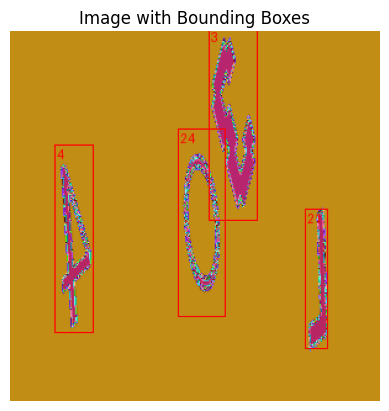

In [7]:

# dataset = CaptchaDataset(preprocessed_dir, labels_dir, downscale_factor=False, augment=True)
# Load one sample for visualization
image, bboxes, labels = train_dataset[0]

print("Image Shape:", image.shape, image[0][0][0:10])
print("Bounding Boxes:", bboxes)
print("Labels:", labels)


def plot_image_with_bboxes(image, bboxes, labels, title="Image with Bounding Boxes"):
    img_height, img_width = image.shape[1], image.shape[2] 
    
    # Scale normalized bboxes to absolute pixel values for visualization
    # TODO: --> * 4 used for non flipped images: works
    # Issue with flipped ones
    # How to test: set flip prob to one and you will see :)
    bboxes[:, [0, 2]] *= img_width
    bboxes[:, [1, 3]] *= img_height

    # Convert to integer values for plotting
    bboxes_abs = bboxes.to(torch.int)

    print("BBoxes for Visualization:", bboxes_abs)

    # Ensure labels are strings
    if isinstance(labels, torch.Tensor):
        labels = labels.tolist()
    labels = [str(l) for l in labels]

    # TODO: Image to RGB

    # Draw bboxes
    image_with_boxes = draw_bounding_boxes(image, bboxes_abs, labels=labels, colors="red", width=1)

    # image tensor to NumPy for visualization
    img = image_with_boxes.permute(1, 2, 0).numpy()

    plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.show()


plot_image_with_bboxes(image, bboxes, labels)


# 1. Model

In [8]:
from src_code.model_utils.backbone import VGG16Backbone
from src_code.model_utils.ssd import SSDCaptcha

# Initialize the SSD model
model = SSDCaptcha(num_classes=config.num_classes)
# Print model summary
print(model)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

n_boxes = {'conv4_3': 4, 'conv7': 4, 'conv8_2': 4, 'conv9_2': 4}
SSDCaptcha(
  (backbone): VGG16Backbone(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stri

In [10]:
test_input = torch.randn(1, 3, 300, 300).to(device)  # Maintain rectangular aspect ratio
pred_locs, pred_cls, fm_info = model(test_input)
print(f"Localization Output Shape: {pred_locs.shape}")
print(f"Classification Output Shape: {pred_cls.shape}")
print(f"fm_info: {fm_info = }")
# Generating default boxes for different feature maps
feature_map_shapes = fm_info.values()  # Example feature map sizes for rectangular input
default_boxes = model.generate_default_boxes(fm_info)
print(f"Generated {default_boxes.shape[0]} default boxes.")

Localization Output Shape: torch.Size([1, 7720, 4])
Classification Output Shape: torch.Size([1, 7720, 37])
fm_info: fm_info = {'conv4_3': [38, 38], 'conv7': [19, 19], 'conv8_2_feats': [10, 10], 'conv9_2_feats': [5, 5]}
Generated 7720 default boxes.


## 1.1 Model Architecture

In [11]:
print(model.backbone)
print(model.auxiliary_convs)
print(model.prediction_head)

VGG16Backbone(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (co

## 1.2 Loss Function

In [12]:
from src_code.model_utils.loss import MultiBoxLoss
default_boxes = torch.Tensor([[0.5000, 0.1250, 0.5000, 0.1250],[0.5000, 0.3750, 0.5000, 0.1250],
        [0.5000, 0.6250, 0.5000, 0.1250],[0.5000, 0.8750, 0.5000, 0.1250],
        [0.5000, 0.1250, 0.5000, 0.0625],[0.5000, 0.3750, 0.5000, 0.0625],
        [0.5000, 0.6250, 0.5000, 0.0625],[0.5000, 0.8750, 0.5000, 0.0625]])
# (1, 8, 4)
locs_pred = torch.Tensor([[[0., 0., 0., 0.],
                     [0., 0., 0., 0.],
                     [0., 0., 0., 0.],
                     [0., 0., 0., 0.],
                     [0., 0., 0., 0.],
                     [0., 0., 0., 0.],
                     [0., 0., 0., 0.],
                     [0., 0., 0., 0.]]])

# (1, 8, 36)
cls_pred = torch.Tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
     [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
     [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
     [0.0000, 0.0000, 0.0000, 0.0000, 0.9000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
     [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
     [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
     [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
     [0.0000, 0.0000, 0.0000, 0.0000, 0.9000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]])
boxes = torch.Tensor([[[ 61,  36, 139, 115], [297,  10, 386,  98], [509,  26, 572,  90]]])
labels = torch.Tensor([[21,  0, 33]])

# calculate loss
mbl = MultiBoxLoss(default_boxes, config)
loss, debug_info = mbl(locs_pred, cls_pred, boxes, labels)
expected_loss = 10.8635

/var/lit2425/jenga/suman/pjf/computer_vision/captcha_env/lib/python3.10/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [13]:
loss

tensor(3885.4417)

In [14]:
debug_info

{'overlap_gt_def_boxes': [tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]])],
 'db_for_each_obj': [tensor([0, 0, 0])],
 'db_indices_for_each_obj': [tensor([0, 0, 0])],
 'overlap_value_for_each_db': tensor([1., 0., 0., 0., 0., 0., 0., 0.]),
 'self.label_each_db': [tensor([33., 36., 36., 36., 36., 36., 36., 36.])],
 'match': [tensor([ True, False, False, False, False, False, False, False])],
 'matched_gt_boxes': [tensor([[0.2500, 0.0625, 0.7500, 0.1875],
          [0.2500, 0.0625, 0.7500, 0.1875],
          [0.2500, 0.0625, 0.7500, 0.1875]])],
 'gt_locs': [tensor([[10800.0000,  4630.0000,    24.1814,    31.1916],
          [ 1990.0000,  6010.0000,    25.2493,    32.2444],
          [ 1990.0000,  5990.0000,    25.2493,    32.2444],
          [ 1990.0000,  5970.0000,    25.2493,    32.2444],
          [ 1990.0000, 12060.0000,    25.2493,    35.7102],
          [ 1990.0000, 12020.0000,    25.2493,    35.7102],


# 2. Training

In [15]:
from torch.optim import SGD
from src_code.model_utils.train_utils import CaptchaTrainer

config = ConfigParser(configs_dict)
config = config.get_parser()

# Automatically detect if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure `config.device` is updated correctly
config.device = device

# Move model to the correct device
model.to(config.device)
print(f"Using device: {config.device}")

# Ensure default boxes are defined
print(f"Default boxes shape: {default_boxes.shape}")  # Check before passing

# Ensure dataloader has data
assert len(dataloader) > 0, "Error: Training dataloader is empty!"
print(f"Number of batches in train_loader: {len(dataloader)}")

print(f"config attributes: {dir(config)}")  # Check attributes exist
print(f"config.pos_box_threshold: {config.pos_box_threshold}")  # Ensure it's defined

# Create optimizer
optimizer = SGD(
    model.parameters(),
    lr=config.lr,  # Use object attribute instead of dictionary key
    momentum=config.momentum,
    weight_decay=config.weight_decay
)

# Define loss function
loss_fn = MultiBoxLoss(default_boxes, config)

# Create trainer
trainer = CaptchaTrainer(
    model=model,
    train_loader=dataloader,
    val_loader=None,  # You can set a validation loader if needed
    test_loader=None,  # You can set a test loader if needed
    loss_fn=loss_fn,
    optimizer=optimizer,
    config=config
)

# Train the model
num_epochs = config.epochs
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}:")
    trainer.train_step(epoch)
    print("---------------------------------------------")

print("Training complete!")


config = {'data_configs': {'train_path': 'datasets/utn_dataset_curated/part2/train', 'val_path': 'datasets/utn_dataset_curated/part2/val', 'test_path': 'datasets/utn_dataset_curated/part2/test', 'preprocessing_related': {'mean': 0.5, 'std': 0.5, 'downscale_factor': 4}, 'dataset_related': {'train_preprocessed_dir': '../datasets/utn_dataset/part2/train/images/', 'val_preprocessed_dir': '../datasets/utn_dataset/part2/val/images/', 'test_preprocessed_dir': '../datasets/utn_dataset/part2/test/images/', 'train_labels_dir': '../datasets/utn_dataset/part2/train/labels/', 'val_labels_dir': '../datasets/utn_dataset/part2/val/labels/', 'augment': True, 'shuffle': False}, 'augmentation_related': {'flip_prob': 0.5, 'scale_range': (0.8, 1.2), 'zoom_prob': 0, 'saturation_prob': 0}}, 'model_configs': {'epochs': 1, 'batch_size': 32, 'device': 'cuda', 'checkpoint': None, 'backbone': {'name': 'VGG16', 'num_stages': 6}, 'loss': {'alpha': 1, 'pos_box_threshold': 0.5, 'hard_neg_pos': 3}, 'optim': {'name': '

IndexError: The shape of the mask [32, 8] at index 1 does not match the shape of the indexed tensor [32, 7720, 4] at index 1

# 3. Evaluation